# Monte Carlo GPI

The idea behind Monte Carlo methods for RL is very straightforward, we want to do this via GPI, where we try to estimate the value of state-action pairs based on sampling. 

Essentialy we will run episodes by following a policy $\pi$(which can start as random). Then we will update an estimate of our $q$ function by the incrementing state-action pairs that occured in the episode:

$$ q(s, a) \leftarrow q(s, a) + \frac{G(s, a) - q(s, a)}{u(s, a) + 1}$$

Where $u(s, a)$ is the count of updates for this state-action pair, and $G(s, a)$ is the return we got in this episode after taking action $(s, a)$ for the first time(we will implement first visit Monte Carlo). This is just averaging over all first-visit results.

After that we update $\pi$ as an $\epsilon$-greedy policy over $q$. Note that we must have $\pi(s, a) > 0$ for all state-action pairs, else we can't guarantee enough exploration, and that's why we go with an $\epsilon$-greedy policy.

For this notebook we will explore how we can create this agent in a straightfoward way. The code is a little messy since we are doing things step by step. In the codebase there is a proper implementation of this agent, which we can use later.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from utils.returns import returns_from_reward
from utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.worlds import small_world_01
from notebooks.utils.basics import basic_actions, basic_reward

np.random.seed(63)

# World

Monte Carlo is by no means an efficient method, so we will use a small deterministic word for this example.

In [2]:
gworld = small_world_01
print(get_world_str(gworld))

4 ✘          

3    ☠  █    

2            

1 █  █       

0 ⚐          

  0  1  2  3 


# Agent

Here we will define a simple Agent class to store relevant information and simple methods. 

The agent as we are defining isn't aware of the world it is in, which means that it doesn't know what are the possible states it can reach. This seems like a natural choice for me, as I don't see why we would require this knowledge, but this is somewhat different from some implementations described in the literature, although in practice this doesn't change.

Important properties of our agent are its reward function and gamma value, which will dictate what he is trying to accomplish. The policy and $q$ function are also naturally a part of the agent.

In [3]:
def reward(e):
    if e == 1:
        return 0
    elif e == -1:
        return -10
    else:
        return -1


class BasicAgent:
    def __init__(
        self,
        reward_function,
        actions=None,
        policy=None,
        gamma=1,
    ):
        self.actions = actions if actions is not None else tuple(Action)
        self.policy = Policy if policy is not None else get_random_policy(self.actions)
        self.reward_function = reward_function
        self.gamma = gamma
        self.q_map: dict[tuple[State, Action], float] = {}
        self.u: dict[tuple[State, Action], int] = {}

        self.q = lambda s, a: self.q_map.get((s, a), 0)

    def get_visited_states(self) -> set:
        return {x for x, y in agent.q_map.keys()}


agent = BasicAgent(reward_function=reward, actions=basic_actions)

# Episodes

Alright in order to learn the agent needs to interact with the world, this is done through episodes. 

An epidsode consists of an agent starting in the initial position, selecting an action, going to a new position and receving an 'effect'(which will be interpreted by agent and transformed in a reward). Then it repeats the process until it reaches a terminal state or a certain threshold of steps is reached.

In [4]:
def run_episode(agent, world, initial_state=None, max_steps=int(1e7)):

    state = initial_state if initial_state is not None else world.initial_state
    episode_terminated = False
    episode_states = [state]
    episode_actions = []
    episode_rewards = []

    for _ in range(max_steps):
        action = sample_action(agent.policy, state, agent.actions)
        state, effect = world.take_action(state, action)
        reward = agent.reward_function(effect)

        episode_actions.append(action)
        episode_states.append(state)
        episode_rewards.append(reward)

        if state.kind == "terminal":
            episode_terminated = True
            break

    return episode_terminated, episode_states, episode_actions, episode_rewards

In [5]:
episode_terminated, episode_states, episode_actions, episode_rewards = run_episode(
    agent, gworld
)
episode_returns = returns_from_reward(episode_rewards)

In [6]:
def get_sar_str(
    episode_states, episode_actions, episode_rewards, episode_returns, world
):
    sars_str = ""
    for i in range(len(episode_states)):
        if episode_states[i].kind == "terminal":
            sars_str += f"terminated at state: {episode_states[i]}"
            break
        else:
            sars_str += f"state: {episode_states[i]} | action: {episode_actions[i]} | reward: {episode_rewards[i]:.2f} | return: {episode_returns[i]:.2f} \n"

    return sars_str


print(
    get_sar_str(
        episode_states, episode_actions, episode_rewards, episode_returns, gworld
    )
)

state: initial at (0, 0) | action: left | reward: -1.00 | return: -216.00 
state: initial at (0, 0) | action: down | reward: -1.00 | return: -215.00 
state: initial at (0, 0) | action: up | reward: -1.00 | return: -214.00 
state: initial at (0, 0) | action: left | reward: -1.00 | return: -213.00 
state: initial at (0, 0) | action: up | reward: -1.00 | return: -212.00 
state: initial at (0, 0) | action: left | reward: -1.00 | return: -211.00 
state: initial at (0, 0) | action: down | reward: -1.00 | return: -210.00 
state: initial at (0, 0) | action: left | reward: -1.00 | return: -209.00 
state: initial at (0, 0) | action: left | reward: -1.00 | return: -208.00 
state: initial at (0, 0) | action: up | reward: -1.00 | return: -207.00 
state: initial at (0, 0) | action: up | reward: -1.00 | return: -206.00 
state: initial at (0, 0) | action: down | reward: -1.00 | return: -205.00 
state: initial at (0, 0) | action: right | reward: -1.00 | return: -204.00 
state: empty at (1, 0) | action:

# Learning

Monte Carlo agents are expected to 'learn' after each completed episode. By this I simply mean improving his expectations on how good taking an action in a state is, i.e. reestimating its q function.

In [7]:
def first_visit_return(states, actions, returns):
    fvr = {}
    for i in range(len(returns)):
        if (sa := (states[i], actions[i])) not in fvr:
            fvr[sa] = returns[i]

    return fvr


def update_q(agent, fvr):

    for s, a in fvr:
        agent.u[(s, a)] = agent.u[(s, a)] + 1 if (s, a) in agent.u.keys() else 1
        agent.q_map[(s, a)] = (
            agent.q_map[(s, a)] + (fvr[(s, a)] - agent.q(s, a)) / agent.u[(s, a)]
            if (s, a) in agent.q_map.keys()
            else fvr[(s, a)]
        )


#     agent._update_q_function()

fvr = first_visit_return(episode_states, episode_actions, episode_returns)
update_q(agent, fvr)

# Improving

So learning is not necessarily useful by itself, we also want the agent to be able to take better decision, so we improve the policy, by making it $\epsilon$-greedy over our improved q function.

In [8]:
def get_best_action(s, q, actions):
    best_score = float("-inf")
    for a in actions:
        if (score := q(s, a)) > best_score:
            best_score = score
            best_action = a
    return best_action


def get_e_greedy_policy(q, states, actions, epsilon=0.1):
    policy_map = {}
    p_0 = epsilon / len(actions)
    for s in states:
        best_action = get_best_action(s, q, actions)
        for a in actions:
            policy_map[(s, a)] = p_0 + (1 - epsilon if a == best_action else 0)

    return (
        lambda s, a: policy_map[(s, a)]
        if (s, a) in policy_map.keys()
        else 1 / len(actions)
    )


pi0 = get_e_greedy_policy(
    agent.q, agent.get_visited_states(), agent.actions, epsilon=0.1
)

In [9]:
pi0r = get_policy_rec(pi0, gworld, agent.actions)
print(get_policy_rec_str(pi0r, gworld))

 ✘  ↑  ↑  → 

 ↑  ☠  █  → 

 →  ←  →  ↓ 

 █  █  ↑  ↓ 

 →  ↑  →  ↓ 




# Looping

Of course an agent isn't abble to get very good over a single episode, so lets put this in a GPI loop where it will keep learning and improving.

In [10]:
total_episodes = 200

agent = BasicAgent(
    reward_function=reward,
    actions=basic_actions,
)
returns_history = []
lengths_history = []

for i in range(total_episodes):
    episode_terminated, episode_states, episode_actions, episode_rewards = run_episode(
        agent, gworld
    )
    episode_returns = returns_from_reward(episode_rewards)

    if episode_terminated:
        fvr = first_visit_return(episode_states, episode_actions, episode_returns)
        update_q(agent, fvr)

        agent.policy = get_e_greedy_policy(
            agent.q, agent.get_visited_states(), agent.actions, epsilon=0.1
        )

    returns_history.append(episode_returns[0])
    lengths_history.append(len(episode_returns))

pi_r = get_policy_rec(agent.policy, gworld, agent.actions)
print(get_policy_rec_str(pi_r, gworld))

 ✘  ←  ↑  → 

 ↑  ☠  █  → 

 ↑  ←  ←  → 

 █  █  ↑  ↑ 

 →  →  ↑  ← 




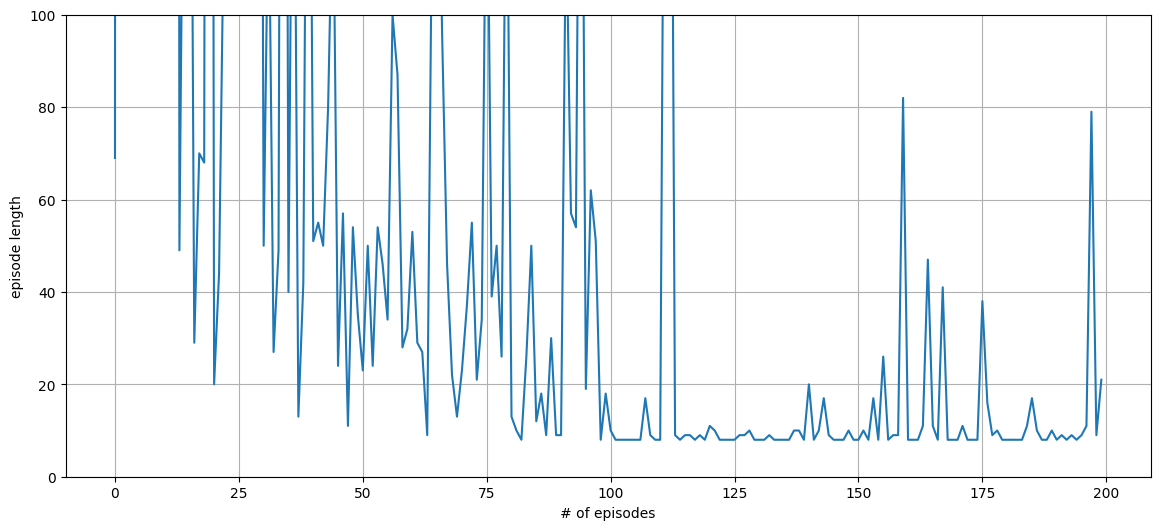

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(lengths_history)

ax.set(xlabel="# of episodes", ylabel="episode length", ylim=[0, 100])
ax.grid()

plt.show()

The agent improved a lot! However... this clearly isn't ideal.

There are two main problems here, one is that by following this $\epsilon$-greedy policy the agent is very unlikely to reach certain states, like (0,2), this makes learning good estimates for $q$ very hard in this states. This can be particularly problematic if we have 'stable' sub-optimal policies, where many exploration steps would be needed to get better estimates; this is kinda the case here, on state (2,2) for instance, where left is a better action, but to learn this we would need to also select ((1,2), left), ((0,2), up) and ((0,3), up) which is unlikelly to happen(less then $\epsilon^2(1-\epsilon)^2$ episodes that reach (2,2) will select this actions) under the current policy.

The other problem is that the agent really wants to avoid getting near the trap, that's because its stochastic behavior has a chance to throw it in the trap at any step. This leads to a solution that is non-optimal (in the sense that the geedy policy over the final estimate of $q$ isn't optimal), but very safe - it will infact be the optimal $\epsilon$-greedy policy if we run this long enough, which is clearly as good as we can hope for this approach.

In theory both problems could be dealt with by running this process a lot longer and choosing a small enough value for epsilon or decreasing it appropriately. In practice this is just too slow, that's because the two problems compete with each other, as small values of $\epsilon$ mean less exploration, which makes learning good actions in 'rare' states very difficult, but large values makes the agent more likely to fall into the trap by exploring, which makes it averse to states near the trap. 

The conclusion is that the agent learns, but it has some problems and we need better ways of dealing with them.